### GLACIER AREA CALCULATOR ### 

This project will primarily use the USGS Python Package to identify, download and present Landsat imagery between 1985 - 2024 at the Kenai Mountains in Alaska.


##  TO DO LIST FOR THE STUDY  ## 

---AFTER LANDSAT DONE-----
- Create a table and shapefile with the results

In [4]:
# List of modules required for this study

# usgs will need to be downloaded to the users conda environment (using pip install usgs)
import usgs
from usgs import api
import os
import requests
import tarfile
import rasterio
from rasterio.windows import from_bounds
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape
import numpy as np
import matplotlib.pyplot as plt

## Getting Logged in and Set up ##

In order for this script to work, users will require both a valid account on the USGS Earth Explorer Website (https://earthexplorer.usgs.gov/) and an authorised Api Key (This can be applied for by following the attached link https://ers.cr.usgs.gov/).

In [5]:
# Open and read the Username and Api Key/Token for the USGS account
with open('C:/Users/couse/.usgs_user', 'r') as usertext: # Enter user directory
    username = usertext.read()
with open('C:/Users/couse/.usgs_token', 'r') as tokentext:  # Enter user Api token
    password = tokentext.read()
    
# Log in using the above information 
login = api.login(username, password, save=True)

# Extract the API Key (token) separately as it will be needed to search for and download Landsat scenes
api_key = login['data']
print("Log in successful")

Log in successful


To identify and search for the required Landsat scenes in this study we are going to use the api.scene_search() function as this will be the primary method for getting the correct images before we download them. 

For the scene searches in this study we are going to use the following:
- Dataset ID (dataset)
- Latitude and Longitude (lat and lng)
- Earth Explorer allows us to create a bounding box to get available images that cover those areas (ll and ur - Lower left corner and Upper Right corner for the bounding box respectively)
- Start and End date (start_date and end_date)
- The extracted Api key (api_key)

Future adaptations could include filtering image selection based on cloud coverage to ensure that images used are cloud free.

We are going to use dataset_search to identify what Landsat datasets are available and importantly the exact 'dataset' which we will use to download and extract the specific scenes needed for this study

In [ ]:
# Landsat imagery comes from the EarthExplorer dataset (node), we will do a search and print out all Landsat datasets in the Earth Explorer node
satellite_avail = api.dataset_search("landsat", "EE")
for dataset in satellite_avail['data']:
        print(dataset['datasetAlias']) #Prints out names of all available datasets

All available scenes are printed above. In this project we are going to use the 'landsat_tm_c2_l1' (1986, 1995 and 2009) and the 'landsat_ot_c2_l1' (2014 and 2024) datasets to acquire imagery of the Kenai Mountain Glaciers. The next step is to search for the Landsat images that will be used for the study. You can get the Bounding box coordinates and landsat image information on the USGS Earth Explorer website (https://earthexplorer.usgs.gov/).
In this study, a set date has been used to get the exact image required, however the date range can be adjusted to get see the available products ether across a range of dates or on different days.

## Downloading and analysing the 1986 Landsat Scene ## 

In [ ]:
# In this cell we will use the search function to get the 'entity_id' Landsat scene used in the study
results_1986 = api.scene_search(
    # Landsat dataset used for 1986 image
    dataset = "landsat_tm_c2_l1", 
    # The latitude of the image (Can be changed for different locations)
    lat = 60.09345, 
    # The longtitude of the image (Can be changed for different locations)
    lng = -151.07395, 
    # The Latitude and Longtitude of the Lower left corner of the Bounding Box in EE
    ll = {"longitude" : -151.7075, "latitude" : 59.1140}, 
    # The Latitude and Longtitude of the Upper Right corner of the Bounding Box in EE
    ur = {"longitude" : -150.1913, "latitude" : 59.9276},
    # The start date of the search range
    start_date = "1986-09-11", 
    # The end date of the search range
    end_date = "1986-09-13", 
    # The Users Api key
    api_key=api_key 
)
# Loop through each 'scene' that appears in the results and will print out the 'entity_id' which will be used in the dataset download.
for scene in results_1986['data']['results']:
    print("The Entity ID of the 1986 Landsat scene is",(scene['entityId'])) 

Now that the Entity ID is known we can now download the Band files which we will use to build a false colour composite image of the Kenai Mountains.

In [ ]:
# This cell will provide the different download options for the Landsat dataset
api.dataset_download_options("landsat_tm_c2_l1")                             

In this study we are going to use the 'Landsat Collection 2 Level-1 Product Bundle' to download all the different bands. For all downloads we are using the product_id that incldues the downlaod system 'ls_zip'. The product ID code with the downlaod option will be used in the download request to download the tar file into the repository. We are download all of the datasets as a tarfile as when the images are download from the USGS dataset it combines all images into a single file. If images are downloaded as a zip file it doesn't allow the user to extract the file contents as all images are individually compressed.

Therefore, in this project all images that are downloaded from the USGS are downloaded in the tar file format so that the user can used the tarfile module to easily extract images into the directory folder.

The next cell will download the Landsat band images associated with the entity_id that we got from the scene search above. The download_requests functions will return a URL which can be used to download the band file folder to our chosen directory. We will use this URL to direct our download to the 1986Data folder as a Tar file.

In [6]:
# We use the OS module to create a new folder for all the Kenai Mountains data to be stored 
# We also create a '1986Data' folder to store data that belongs to this time period
os.makedirs("KenaiMountains/1986Data", exist_ok=True) 

# This functions will return the available download urls for the Landsat scene
KM_1986 = api.download_request(
    dataset="landsat_tm_c2_l1", # Landsat dataset
    entity_id="LT50690181986255XXX05", # Landsat scene entity id returned from the scene search
    product_id="5e83d0a0f94d7d8d", # Product id for the Landsat Collection 1 Level 1 ls.zip
)

 # Download the Landsat data using the url provided by the download_request function from the EE node
if 'data' in KM_1986 and 'availableDownloads' in KM_1986['data']:
    # Identifies if the above Landsat is available to be downloaded
    KM_1986Avail = KM_1986['data']['availableDownloads'] 
    if KM_1986Avail:
        KM1986downloadurl = KM_1986Avail[0]['url']# Use the first download url retrieved from download_request
        KM_1986File = os.path.join("KenaiMountains/1986Data", f"LT50690181986255XXX05.tar")# Set the file path to download into the '1986Data' folder created above
        KM1986url = requests.get(KM1986downloadurl, stream=True)# Use the requests module to get the URL stored in the 'KM1986downloadurl' variable

        # Write the downloaded file in binary mode to avoid corruption during download
        with open(KM_1986File, "wb") as f: 
            # Download in 8Kb chunks to avoid issues with larger datasets (more relevant to 'landsat_ot_c2_l1' scenes
            for chunk in KM1986url.iter_content(chunk_size=8192): 
                # Then we use .write to download the data in chunk to our chosen folder
                if chunk:
                    f.write(chunk)

# When the download is successful it will print the following text
# The download may take a few minutes but can be monitored by refreshing the directory folder (1986Data)
print("1986 Kenai Mountain images downloaded!")

1986 Kenai Mountain images downloaded!


In [7]:
# We extract the Landsat images from the .tar file that we downloaded from the USGS EE node
with tarfile.open("KenaiMountains/1986Data/LT50690181986255XXX05.tar", 'r') as KM1986Tar:
    KM1986Tar.extractall("KenaiMountains/1986Data")

# Text will display whenever images have been successfully extracted into the 1986Data folder
print("Images have been successfully extracted")

Images have been successfully extracted


Now that the images for the 1986 dataset have been downloaded we will build a false colour composite image of the Landsat scene

As part of this we are going to use Rasterio to open, read and stack the images to create a new 3D array (using NumPY). 
This stack combines the necessary band combination to create a False Colour Composite Image of the Landsat scene.
We then use matplotlib to present the created False Colour Composite image to ensure that the correct bands have been used and thqt the stack has been successful.

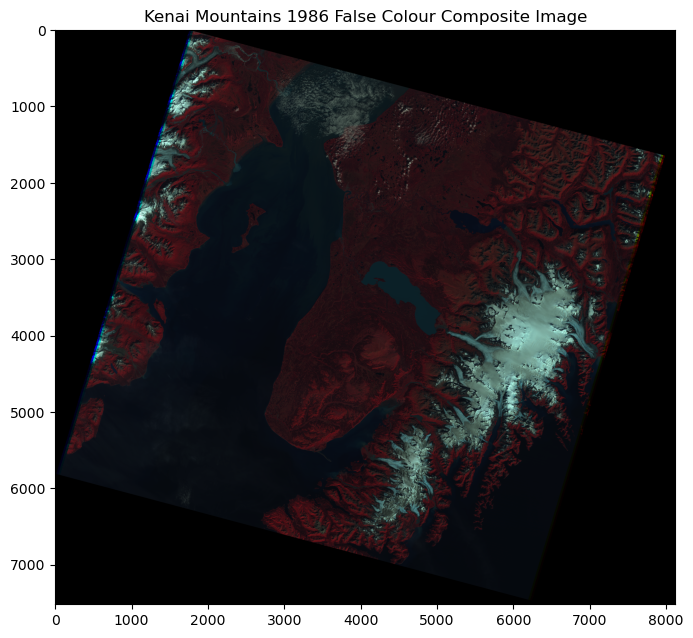

In [8]:
# We use Rasterio to open the paths to the Landsat scene Band TIF files
with rasterio.open("KenaiMountains/1986Data/LT05_L1TP_069018_19860912_20200917_02_T1_B4.TIF") as KM1986_B4IMG:
    KM86B4 = KM1986_B4IMG.read(1) # The paths are defined as B4 (NIR), B3 (Red) and B2 (Green) respectively
with rasterio.open("KenaiMountains/1986Data/LT05_L1TP_069018_19860912_20200917_02_T1_B3.TIF") as KM1986_B3IMG:
    KM86B3 = KM1986_B3IMG.read(1)
with rasterio.open("KenaiMountains/1986Data/LT05_L1TP_069018_19860912_20200917_02_T1_B2.TIF") as KM1986_B2IMG:
    KM86B2 = KM1986_B2IMG.read(1)

# We stack bands using NumPy module to create a single 3D Array
KM1986_FFCstack = np.dstack((KM86B4, KM86B3, KM86B2))

# Print the Stacked image to show the False Colour Composite for the 1986 Landsat scene
plt.figure(figsize=(8, 8)) # create a figure of size 8x8 (representing the page size in inches)
plt.imshow(KM1986_FFCstack) # The figure will show the False Colour Composite Image for 1986
plt.title("Kenai Mountains 1986 False Colour Composite Image") # The Figure Title
plt.show()

Now that the False Colour Composite Image has been successfully built. We will save the image to the 1986Data folder so that it can be trimmed and then used for the glacier mask later in the session.

We update image profile for the False Colour Composite image using the NIR band as the source, this ensures that the created TIF keeps the same metadata structure as it will be used in the following steps to create a trim and Glacier mask.

The metadata in the profile includes:
- Pixel Height and Width
- Coordinate System
- Transformation
- Driver/File Format

We then update the Metadata of the new image to include:
- The number of bands (as the NIR is a single band)
- dtype (ensures that the image is saved as a TIF)

In [9]:
# Now that the False Colour Composite Image has been created, we will need to save the image  

# First we will open one of the bands to get its profile and use it as a source
with rasterio.open('KenaiMountains/1986Data/LT05_L1TP_069018_19860912_20200917_02_T1_B4.TIF') as KM1986_source:
    KM1986_ImgProfile = KM1986_source.profile

# We then update the profile for all of the bands in the False Colour Composite using the source
KM1986_ImgProfile.update(
    count=3,  # The count is set to 3 as we are using 3 bands (NIR, Red and Green)
)

# Finally we save the False Colour Composite to the Kenai Mountains folder
with rasterio.open('KenaiMountains/1986Data/KM1986_FullFCC.TIF', 'w', **KM1986_ImgProfile) as KM1986_FCCdownload:
# We then use the .write function to save the False Colour image to the Kenai Mountains 1986 folder
# We use .transpose to change the shape of the array to match the format expected by rasterio when writing/saving the image to the folder (Bands, Width and Height respectively) 
    KM1986_FCCdownload.write(KM1986_FFCstack.transpose(2, 0, 1))  
print("Image has been saved as KM1986_FullFCC.TIF")

Image has been saved as KM1986_FullFCC.TIF


Now that the Full False Colour Composite Image for the 1986 Landsat scene ahs been successfully created. We need to trim the image so that the only area included in the Glacier Mask is the Kenai Mountains.

This is useful as it prevent Glacier Ice and Snow from adjacent mountains influencing the total Glacier area for the 1986 period.

To do this we need to adjust the bounds (extent) of the Full False Colour Composite Image to only include the Kenai Mountains.

To include more area (zoom out) on the image:
- Decrease 'left'
- Increase 'right'
- Decrease 'bottom'
- Increase 'top'

To include less area (Zoom in):
- Increase 'left'
- Decrease 'Right'
- Increase 'bottom'
- Decrease 'top'

In [ ]:
# Use Rasterio to get the Bounds of the full False Colour Composite Image
with rasterio.open('KenaiMountains/1986Data/KM1986_FullFCC.TIF') as KM1986FCCsrc:
    print(KM1986FCCsrc.bounds)

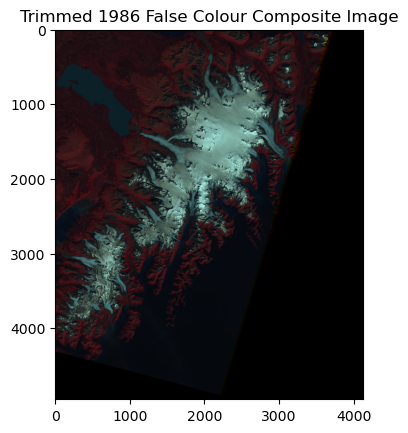

In [10]:
# Define a new Bounding Box by changing the values from .bound above
BoundingBox = {"left": 601185.0,"bottom": 6551985.0, # Values can be adjusted
               "right": 734815.0,"top": 6700615.0} # Values can be adjusted

# Open the Full False Colour Composite Image
with rasterio.open('KenaiMountains/1986Data/KM1986_FullFCC.TIF') as KM1986Cropsrc:
    # Use the new BoundingBox to create a trim window
    KM1986Trim = from_bounds(BoundingBox["left"], BoundingBox["bottom"],
                             BoundingBox["right"], BoundingBox["top"], 
                             transform=KM1986Cropsrc.transform) # transform helps convert the pixel value in the Bounding box to real coordinate on the image
    
    # Read the data within the trim window
    KM1986Trim_Data = KM1986Cropsrc.read(window=KM1986Trim)
    # Update the metadata and profile of the trimmed area
    KM1986Trim_Transform = KM1986Cropsrc.window_transform(KM1986Trim)
    KM1986Trim_profile = KM1986Cropsrc.profile.copy()
    # Update the Trimmed TIF metadata to include the correct Pixel Height and Width which will update the Pixel Count
    KM1986Trim_profile.update({
        "height": KM1986Trim_Data.shape[1], # Update the Pixel Height
        "width": KM1986Trim_Data.shape[2], # Update the Pixel Width
        "transform": KM1986Trim_Transform # Update the Pixel Values to include Pixels within the Trim Window
    })

# Save the trimmed TIF to a new file 
with rasterio.open('KenaiMountains/1986Data/KM1986_FCC_Trim.TIF', "w", **KM1986Trim_profile) as dst:
    dst.write(KM1986Trim_Data)

# Display the trim to see if the study area is covered and if the trim has been successful
# This can serve as a visual checker if the Bounding box needs to be adjusted
plt.imshow(KM1986Trim_Data.transpose((1, 2, 0))) # .transpose reorders the image to height (1), width(2), bands(0) the expected format for matplotlib
plt.title("Trimmed 1986 False Colour Composite Image")
plt.show()

By now you should notice that the 1986Data folder is full and contains lots of files that are no longer required in the analysis. 

The next cell is a loop that will remove all of the Landsat Band files as they are no longer required in the study. If there are any issues and a step has been skipped they can be redownlaoded using the download_request cell above.

The file delete will be particularly useful when we use the Landsat 8 images as they are larger. Github has a commit limit of 100mb for a single file, deleting the unnecessary image files will make commiting on GitHub easier and makes the directory folder on the notebook look a lot tidier.

In [65]:
# Create a loop through all files in the 1986Data folder
for KM1986_filenames in os.listdir('KenaiMountains/1986Data'): 
    KM1986_FilePath = os.path.join('KenaiMountains/1986Data', KM1986_filenames) # The variable will loop through all of the filenames in 1986Data folder

    # Identify all Files that are not the Trimmed False Colour Composite Image
    if os.path.isfile(KM1986_FilePath) and KM1986_filenames != 'KM1986_FCC_Trim.TIF':
        # Remove/Delete these files from the 1986Data directory
        os.remove(KM1986_FilePath)
print("Deleted the files that are no longer required (Click Refresh on folder)")

Deleted the files that are no longer required (Click Refresh on folder)


Now that the directory is tidy and we have the Trimmed False Colour Composite image of the Kenai Mountains in 1986. We will create a glacier mask that will highlight all objects on the image with a Reflectance value of 0.3 in all 3 bands (the estimated reflectance value of glacier ice and snow).

To do this we will carry out a pixel based classification of the image. We do this by normalising the Landsat Bands which are datasets with Digital Values of 0-255 (as they are an 8-bit image) to 0-1 (0 = not Glacier ice and snow, 1 = Glacier ice and snow). We then identify all pixels in the image that meet the reflectance threshold value to isolate glacier snow/ice.

After Glacier ice and snow has been identified we will save the glacier mask to a new file, updating the profile metadata from the False Colour Composite Trim to reflect that the new image only has 1 band.

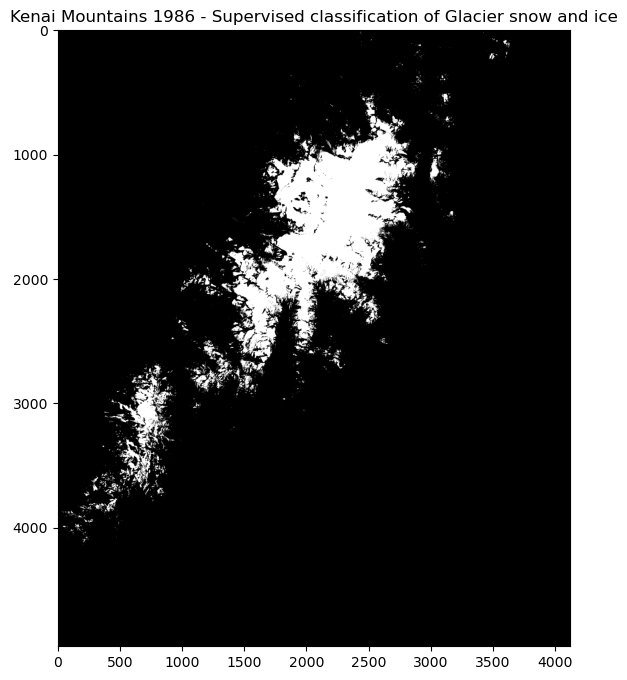

In [12]:
# Open the Trim TIF
with rasterio.open('KenaiMountains/1986Data/KM1986_FCC_Trim.TIF') as KM1986FCCsrc:
    # Read and load the bands from the False colour composite image
    KM1986_Normalised = KM1986FCCsrc.read()
    # Store the essential metadata from the Trim image
    KM1986_profile = KM1986FCCsrc.profile

# The Landsat bands are Digitial Numbers so we then will normalize bands from 0-255 (as they are an 8-bit image) to 0-1
KM1986_Normalised = KM1986_Normalised.astype(np.float32) # Convert the image to a 32-bit floating point to avoid data truncation
KM1986_Normalised /= KM1986_Normalised.max() # Normalise pixel values between 0-1 

# Normalise the glacier mask to highlight all features in the image that have the set reflectance values in each respective band
KM1986_Glacier = (KM1986_Normalised[0] > 0.3) & (KM1986_Normalised[1] > 0.3) & (KM1986_Normalised[2] > 0.3)

# Redefine the glacier mask so it can be saved as new tif
KM1986_Glacier = KM1986_Glacier.astype(np.uint8)

# Update the glacier mask profile so that it only contains 1 band
KM1986_NewProfile = KM1986Trim_profile.copy()
KM1986_NewProfile.update(dtype='uint8', count=1)

# Create a new folder to store the Glacier masks
os.makedirs("KenaiMountains/GlacierMasks", exist_ok=True) 
# Save the glacier mask to the Glacier mask folder
with rasterio.open('KenaiMountains/GlacierMasks/KM1986_GlacierMask.TIF', 'w', **KM1986_NewProfile) as dst:
    dst.write(KM1986_Glacier, 1) 

# Display the glacier mask
plt.figure(figsize=(8, 8))
plt.imshow(KM1986_Glacier, cmap='gray') # Display the glacier mask as a greyscale map
plt.title('Kenai Mountains 1986 - Supervised classification of Glacier snow and ice')
plt.show()

Now that we have created the Glacier mask we will finish the 1986 Landsat scene analysis by calculating the Estimated area of Glacier ice and snow.

In [13]:
# Open the cropped Glacier mask produced in the above step
with rasterio.open('KenaiMountains/GlacierMasks/KM1986_GlacierMask.TIF') as KM1986GlacAreasrc:
    KM1986_GlacierMask = KM1986GlacAreasrc.read(1)  # Read the Glacier Mask band
    transform = KM1986GlacAreasrc.transform
    GlacPixelWidth = transform[0]     # pixel width
    GlacPixelHeight = -transform[4]    # pixel height (The value is negative so we add an "-" to make it positive)

# Calculate the Area per Pixel for the image
KM1986_AreaPP = GlacPixelWidth * GlacPixelHeight  # For Landsat TM it will be 30m x 30m 

# Calculate how many pixels in the image have been identified as snow as per the Glacier mask above
KM1986_GlacPixel = np.sum(KM1986_GlacierMask == 1)

# Calculate the estimated area coverage of Glacier Ice and snow
TotalGlacArea1986 = (KM1986_GlacPixel * KM1986_AreaPP) / 1e6  # Converts the value to square kilometers

# Print the results
print(f"Estimated 1986 Glacier Area = {TotalGlacArea1986:.2f} km²")

Estimated 1986 Glacier Area = 1358.32 km²


## Downloading and analysing the 1995 Landsat Scene ##

Now that we have successfully got the estimated glacier area for 1986 we repeat the same process for the 1995 and 2009 dataset. 

In [14]:
# Use the scene_search function to get the product id of the 1995 Landsat scene
results_1995 = api.scene_search(
    # Landsat dataset used for 1995 image
    dataset = "landsat_tm_c2_l1", 
     # The latitude of the image (Can be changed for different locations)
    lat = 60.12735,
    # The longtitude of the image (Can be changed for different locations)
    lng = -151.22005, 
    # The start date of the search range (Can be changed for different locations)
    start_date = "1995-08-19", 
    # The end date of the search range (Can be changed for different locations)
    end_date = "1995-08-21", 
    # The Users Api key
    api_key=api_key 
)
# Loop through each 'scene' that appears in the results and will print out the 'entity_id' which will be used in the dataset download.
for scene in results_1995['data']['results']:
    print("The Entity ID of the 1995 Landsat scene is",(scene['entityId'])) 

The Entity ID of the 1995 Landsat scene is LT50690181995232XXX01


Next we will use the entity_id from the scene search. As we are using the same product_id to get the Landat Collection 2 Level 1 zip file we don't need to use the dataset options function. 

Similiarly to the 1986 dataset we ar going to create a 1995 folder to download the Landsat band tar file to, and then create a false colour composite image of the 1995 landsat scene.

In [32]:
# Use the OS module to create a folder for the Kenai Mountains 1995 images
os.makedirs("KenaiMountains/1995Data", exist_ok=True) 

# Return the available download URL for the Landsat 1995 scene
KM_1995 = api.download_request( 
    dataset="landsat_tm_c2_l1", # Landsat dataset
    entity_id="LT50690181995232XXX01", # Landsat scene ID
    product_id="5e83d0a0f94d7d8d", # Product ID (Landsat Band file), this will be the same the 1986 dataset as it also using Landsat TM
)

 # Download the Landsat band files using the first URL from the EE node
if 'data' in KM_1995 and 'availableDownloads' in KM_1995['data']:
    KM_1995Avail = KM_1995['data']['availableDownloads'] # Identify available downloaded URLs
    if KM_1995Avail:
        KM1995downloadurl = KM_1995Avail[0]['url']  # Access the first download URL returned from download_request
        KM_1995File = os.path.join("KenaiMountains/1995Data", f"LT50690181995232XXX01.tar")  # Set the file download path to the 1995Data folder
        
        KM1995url = requests.get(KM1995downloadurl, stream=True) # Use requests module to get URL stored in the 'KM1995downloadurl' variable
        
        with open(KM_1995File, "wb") as f: # Create the file and write it in binary mode to issues downloading images
            for chunk in KM1995url.iter_content(chunk_size=8192): # Download in 8kb chunks to prevent errors downloading Landsat Band images
                if chunk:
                    f.write(chunk)

# Print text when the images are successfully downloaded
print("1995 Kenai Mountain images have been downloaded successfully")

1995 Kenai Mountain images have been downloaded successfully


In [33]:
# We extract the Landsat images from the .tar file that we downloaded from the USGS EE node
with tarfile.open('KenaiMountains/1995Data/LT50690181995232XXX01.tar', 'r') as KM1995Tar: # Reads the downloaded tar file
    KM1995Tar.extractall("KenaiMountains/1995Data")

# Display text whenever extract.all has been successfull
print("Images have been successfully extracted")

Images have been successfully extracted


Now that the images for the 1995 Landsat scene have been downloaded and extrcated we will build a false colour composite image of the Landsat scene.

We use Rasterio to open, read and stack the images to create the 3D array just like the 1986 Landsat scene. 
We use matplotlib to present the created False Colour Composite image to ensure that the correct bands have been used and that the stack has been successful.

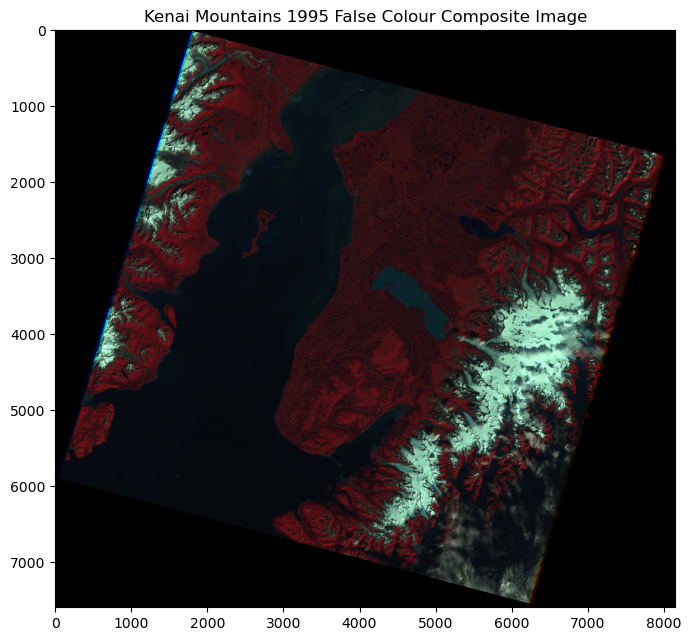

In [39]:
# Use rasterio to open and read the Band TIF files 
with rasterio.open("KenaiMountains/1995Data/LT05_L1TP_069018_19950820_20200912_02_T1_B4.TIF") as KM1995_B4IMG:
    KM95B4 = KM1995_B4IMG.read(1) # Band 4 (NIR)
with rasterio.open("KenaiMountains/1995Data/LT05_L1TP_069018_19950820_20200912_02_T1_B3.TIF") as KM1995_B3IMG:
    KM95B3 = KM1995_B3IMG.read(1) # Band 3 (Red)
with rasterio.open("KenaiMountains/1995Data/LT05_L1TP_069018_19950820_20200912_02_T1_B2.TIF") as KM1995_B2IMG:
    KM95B2 = KM1995_B2IMG.read(1) # Band 2 (Green)

# Stack the bands using NumPy module to create a single 3D Array (False Colour Composite image)
KM1995_FCCstack = np.dstack((KM95B4, KM95B3, KM95B2))

# Print the array to show the false colour composite image of the 1995 Landsat scene
plt.figure(figsize=(8, 8))
plt.imshow(KM1995_FCCstack) # Show the False Colour Composite image
plt.title("Kenai Mountains 1995 False Colour Composite Image")
plt.show()

After the False Colour Composite image has been saved we need to save the image to the 1995Data folder so that it can trimmed and then used for the glacier mask.

Similiarly to what we did for the 1986 Landsat scene, we update the image profile for the 1995 False Colour Composite image using the NIR band (4) as the source, this ensures that the new TIF keeps the same metadata structure as it will be used in the following steps to create a trim and Glacier mask.

In [41]:
# Open the Band 4 TIF to use it as a source profile for the False Colour Composite image
with rasterio.open("KenaiMountains/1995Data/LT05_L1TP_069018_19950820_20200912_02_T1_B4.TIF") as KM1995_source:
    KM1995_ImgProfile = KM1995_source.profile

# Update the profile for all of the bands in the False Colour Composite
KM1995_ImgProfile.update(
    count=3,  # The count is set to 3 as we are using 3 bands (NIR, Red and Green)
    dtype=KM1995_FCCstack.dtype  # Make the saved data type to be the same as the full False Colour Composite image
)

# Save the False Colour Composite image to the 1995Data folder
with rasterio.open('KenaiMountains/1995Data/KM1995_FullFCC.TIF', 'w', **KM1995_ImgProfile) as KM1995_FCCdownload:
# Use .write to save the False Colour image to the 1995Data folder
    KM1995_FCCdownload.write(KM1995_FCCstack.transpose(2, 0, 1)) # .transpose reorders the image to bands/count(2), height (0), width(1)
print("Image has been saved as KM1995_FullFCC.TIF in KenaiMountains1995")

Image has been saved as KM1995_FullFCC.TIF in KenaiMountains1995


We need to trim the 1995 false colour composite image so that the only area included in the Glacier Mask is the Kenai Mountains.
We need to adjust the bounds (extent) of the 1995 Full False Colour Composite Image to only include the Kenai Mountains.
The bounds for the 1995 image will be different as we are using a different image

To include more area (zoom out) on the image:
- Decrease 'left'
- Increase 'right'
- Decrease 'bottom'
- Increase 'top'

To include less area (Zoom in):
- Increase 'left'
- Decrease 'Right'
- Increase 'bottom'
- Decrease 'top'

In [23]:
# Use Rasterio to open and print the Bounds of the False Colour Composite image
with rasterio.open('KenaiMountains/1995Data/KM1995_FullFCC.TIF') as KM1995FCCsrc:
    print(KM1995FCCsrc.bounds)

BoundingBox(left=476985.0, bottom=6552285.0, right=721515.0, top=6780015.0)


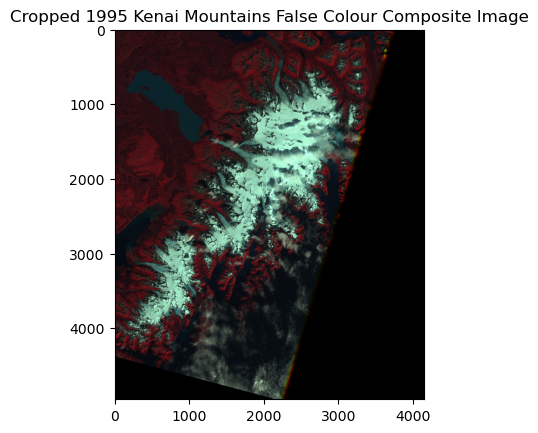

In [42]:
# Crop the 1995 TIF to define a new bounding box highlighting only the Kenai Mountains
BoundingBox = {"left": 601185.0,"bottom": 6551985.0, # Value can be changed to alter the Bounding box
               "right": 734815.0,"top": 6700615.0} # Value can be changed to alter the Bounding box

# Open source raster for the crop (The Full False Colour Composite image)
with rasterio.open('KenaiMountains/1995Data/KM1995_FullFCC.TIF') as KM1995Cropsrc:
    # Define the trim window using the new bounding box 
    KM1995Trim = from_bounds(BoundingBox["left"], BoundingBox["bottom"], 
                             BoundingBox["right"], BoundingBox["top"],
                             transform=KM1986Cropsrc.transform) # transform helps convert the pixel value in the Bounding box to real coordinate on the image
    
    # Read data in the source raster that is within the new Bounding box
    KM1995Trim_Data = KM1995Cropsrc.read(window=KM1995Trim)
    # Update the profile of the new trimmed image so that it can be saved and used in the data analysis
    KM1995Trim_Transform = KM1995Cropsrc.window_transform(KM1995Trim)
    KM1995Trim_profile = KM1995Cropsrc.profile.copy()
    # Updare the Trim metadata to include updated Pixel values 
    KM1995Trim_profile.update({
        "height": KM1995Trim_Data.shape[1], # Updates the Pixel Height
        "width": KM1995Trim_Data.shape[2], # Updates the Pixel Width
        "transform": KM1995Trim_Transform # Updates the Pixel Values to include Pixels within the Trim Window
    })

# Save the trimmed TIF and updated metadata to a new tif file
with rasterio.open('KenaiMountains/1995Data/KM1995_FCC_Trim.TIF', "w", **KM1995Trim_profile) as dst:
    dst.write(KM1995Trim_Data)

# Display the trim
# This can be used to determine if the trim has highlighted the study area
plt.imshow(KM1995Trim_Data.transpose((1, 2, 0))) # .transpose the image to reorder the image to width(1), bands/count(2) and height (0) 
plt.title("Trimmed 1995 Kenai Mountains False Colour Composite Image")
plt.show()

As seen with the 1986 Dataset, the 1995Data is full with image files that we no longer need. To keep the folder tidy and organised we will remove all of the unneccessary files.

If these are needed at a later date they can be redownloaded using the `download_request` function above

In [43]:
# Loop through all files in the 1995Data folder
for KM1995_filenames in os.listdir('KenaiMountains/1995Data/'): 
    KM1995_FilePath = os.path.join('KenaiMountains/1995Data/', KM1995_filenames) 

    # Selects all files apart from the Trimmed TIF
    if os.path.isfile(KM1995_FilePath) and KM1995_filenames != 'KM1995_FCC_Trim.TIF':
        os.remove(KM1995_FilePath) # Deletes all selected files
print("Deleted the files that are no longer required (Click Refresh on folder)")

Deleted the files that are no longer required (Click Refresh on folder)


Now that folder is more organised, we will calculate the total glacier area for the 1995 Landsat image. To do this we will carry out a pixel based classification of the image. We do this by normalising the Landsat Bands which are datasets with Digital Values of 0-255 (as they are an 8-bit image) to 0-1 (0 = not Glacier ice and snow, 1 = Glacier ice and snow). We then identify all pixels in the image that meet the reflectance threshold value to isolate glacier snow/ice (0.3 in all bands).

After Glacier ice and snow has been identified we will save the glacier mask to a new file, updating the profile metadata from the False Colour Composite Trim to reflect that the new image only has 1 band.

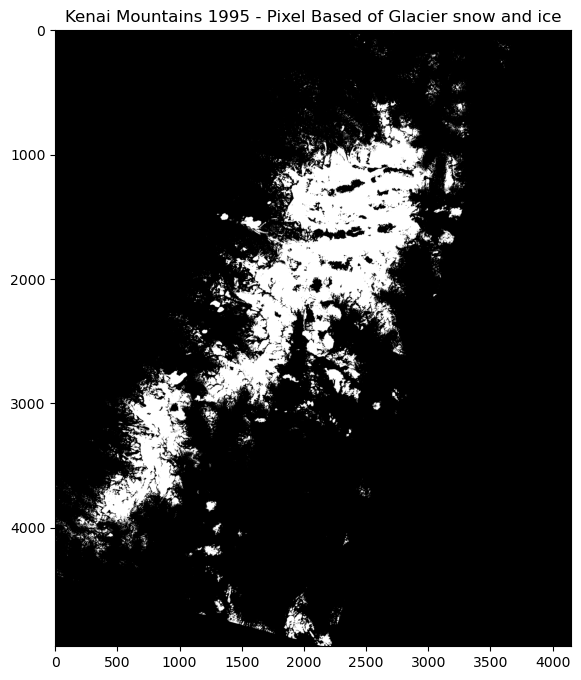

In [60]:
# Open the Trimmed TIF and use it as a source profile
with rasterio.open('KenaiMountains/1995Data/KM1995_FCC_Trim.TIF') as KM1995FCCsrc:
    KM1995_Normalised = KM1995FCCsrc.read()
    KM1995_profile = KM1995FCCsrc.profile

# The Landsat bands are Digitial Numbers so we then will normalize bands from 0-255 to 0-1
KM1995_Normalised = KM1995_Normalised.astype(np.float32)
KM1995_Normalised /= KM1995_Normalised.max()

# Normalise the each bands pixel value so that they are in a common range, set the reflectance value for ice and snow for each band
KM1995_Glacier = (KM1995_Normalised[0] > 0.3) & (KM1995_Normalised[1] > 0.3) & (KM1995_Normalised[2] > 0.3)

# Redefine the Glacier Mask to save it as a new TIF
KM1995_Glacier = KM1995_Glacier.astype(np.uint8)

# Update the profile so that it only has 1 band (Ice/snow)
KM1995_NewProfile = KM1995_profile.copy()
KM1995_NewProfile.update(dtype='uint8', count=1)

# Save the Glacier mask TIF to the Glacier Mask folder
with rasterio.open('KenaiMountains/GlacierMasks/KM1995_GlacierMask.TIF', 'w', **KM1995_NewProfile) as dst:
    dst.write(KM1995_Glacier, 1)

plt.figure(figsize=(8, 8))
plt.imshow(KM1995_Glacier, cmap='gray') # Present the Glacier Mask is greyscale
plt.title('Kenai Mountains 1995 - Pixel Based of Glacier snow and ice')
plt.show()

After the pixel based classification has been successfully completed, we will calculate the glacier area by using the known pixel size in the glacier mask and converting to a real world measurement.

In [68]:
# Open the Glacier mask 
with rasterio.open('KenaiMountains/GlacierMasks/KM1995_GlacierMask.TIF') as KM1995GlacAreasrc:
    KM1995_GlacierMask = KM1995GlacAreasrc.read(1)  # Read the Glacier Mask band
    KM1995_Transfrom = KM1995GlacAreasrc.transform
    GlacPixelWidth = KM1995_Transfrom[0]     # pixel width
    GlacPixelHeight = -KM1995_Transfrom[4]    # pixel height (The value is negative so we add an "-" to make it positive)

# Calculate the Area per Pixel for the image, for Landsat TM it will be 30m x 30m 
KM1995_AreaPP = GlacPixelWidth * GlacPixelHeight  

# Calculate how many pixels in the image have been identified as snow (1) in the Glacier Mask
KM1995_GlacPixel = np.sum(KM1995_GlacierMask == 1)

# Calculate the estimated area of Glacier Ice and snow in the 1995 Landsat scene
TotalGlacArea1995 = (KM1995_GlacPixel * KM1995_AreaPP) / 1e6  # convert to square kilometers

# Print the Estimated Glacier area
print(f"Estimated 1995 Glacier Area: {TotalGlacArea1995:.2f} km²")

Estimated 1995 Glacier Area: 1995.30 km²


## Downloading and analysing the 2009 Landsat Scene ##

As the 2009 Landsat scene also uses the Landsat TM for the image, the steps for getting the Glacier area estimation does not change.

We use the Landsat TM instead of the Landsat ETM+ based on errors with the satellite that causes data voids (stripes) on the images due to an error with the Scan Line Corrector (SLC). Using these images may lead to inaccuracies when calculating the Glacier area, so for that reason Landsat TM data has been used for this year.
Additional information : -(https://www.usgs.gov/faqs/what-landsat-7-etm-slc-data)

In [29]:
# Use the scene_search function to get the product id of the 2009 Landsat scene
results_2009 = api.scene_search(
    # Landsat dataset used for 1995 image
    dataset = "landsat_tm_c2_l1",
    # The latitude of the image
    lat = 60.09405, 
    # The longtitude of the image
    lng = -150.98167, 
    # The start date of the search range
    start_date = "2009-07-08", 
     # The end date of the search range
    end_date = "2009-07-09",
     # The Users Api key
    api_key=api_key
)
# Loop through each 'scene' that appears in the results and  print out the 'entity_id' of the Landsat scene
for scene in results_2009['data']['results']:
    print("The Entity ID of the Landsat scene is",(scene['entityId'])) 

The Entity ID of the Landsat scene is LT50690182009190GLC00


As we are still using the same Landsat satellite for the image download, we do not need to get an updated `product_id` for the Collection 2 Level 1 Band files. We can use the same one as the 1986 and 1995 datasets.

In [44]:
# Use OS to create a 2009Data folder for the Landsat scene band files to be downloaded into
os.makedirs("KenaiMountains/2009Data", exist_ok=True) 

# Return the available download URLs for the Landsat scene Band files
KM_2009 = api.download_request(
    dataset="landsat_tm_c2_l1", # Landsat dataset
    entity_id="LT50690182009190GLC00", # Landsat scene ID (entity_id)
    product_id="5e83d0a0f94d7d8d", # Product ID (Landsat Band file), the same as the 1986 and 1995 datasets
)

# Download the Landsat scene images using the URL returned from download_request in the EE node
if 'data' in KM_2009 and 'availableDownloads' in KM_2009['data']:
    KM_2009Avail = KM_2009['data']['availableDownloads'] # Identifies if the above Landsat is available to be downloaded
    if KM_2009Avail:
        # Access the first download URL returned from download_request
        KM2009downloadurl = KM_2009Avail[0]['url'] 
        # Set the file pathway to download into the 2009Data folder
        KM_2009File = os.path.join("KenaiMountains/2009Data", f"LT50690182009190GLC00.tar") 
        KM2009url = requests.get(KM2009downloadurl, stream=True) # Use requests to get the URL stored in 'KM2009downloadurl' 
        
         # Create the file and write it in binary mode to avoid corruption during the download
        with open(KM_2009File, "wb") as f:
            for chunk in KM2009url.iter_content(chunk_size=8192): # Download the folder in 8 KB Chunks
                if chunk:
                    f.write(chunk)

# Print text when the images are successfully downloaded
print("2009 Kenai Mountain images downloaded!") 

2009 Kenai Mountain images downloaded!


In [45]:
# Extract the Landsat images into the 2009Data folder
with tarfile.open("KenaiMountains/2009Data/LT50690182009190GLC00.tar", 'r') as KM2009Tar:
    KM2009Tar.extractall("KenaiMountains/2009Data")

# Print text if download is successfull
print("Images have been successfully extracted")

Images have been successfully extracted


After the images have been downloaded and extracted into the `2009Data` folder, we are going to build the false colour composite image of the 2009 Landsat scene.

To do this we are going to stack bands 4 (NIR), 3 (Red) and 2 (Green) and create a single 3D array using `NumPY`. 

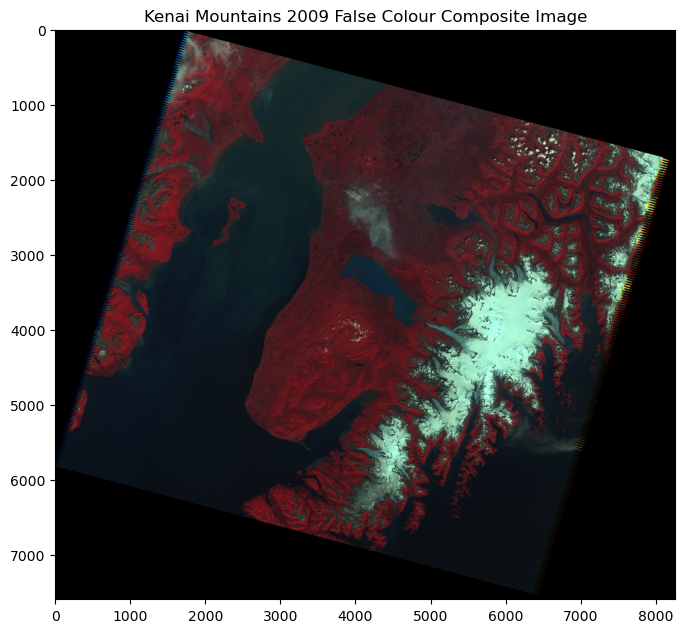

In [47]:
# Use Rasterio to open and read the band TIF files
with rasterio.open("KenaiMountains/2009Data/LT05_L1TP_069018_20090709_20200827_02_T1_B4.TIF") as KM2009_B4IMG:
    KM09B4 = KM2009_B4IMG.read(1) # Band 4 (NIR)
with rasterio.open("KenaiMountains/2009Data/LT05_L1TP_069018_20090709_20200827_02_T1_B3.TIF") as KM2009_B3IMG:
    KM09B3 = KM2009_B3IMG.read(1) # Band 3 (Red)
with rasterio.open("KenaiMountains/2009Data/LT05_L1TP_069018_20090709_20200827_02_T1_B2.TIF") as KM2009_B2IMG:
    KM09B2 = KM2009_B2IMG.read(1) # Band 2 (Green)

# Stack the Landsat bands using NumPy to create a single 3D Array
KM2009_FCCstack = np.dstack((KM09B4, KM09B3, KM09B2))

# Print the stacked band array to show the 2009 false colour composite image 
plt.figure(figsize=(8, 8))
plt.imshow(KM2009_FCCstack)
plt.title("Kenai Mountains 2009 False Colour Composite Image")
plt.show()

Now that the full false colour composite image has been built. We need to save the image to our file directory so that it can be trimmed to show the Kenai Mountains study area.

In [49]:
# Open one of the bands to get its profile and use it as a source for the image
with rasterio.open("KenaiMountains/2009Data/LT05_L1TP_069018_20090709_20200827_02_T1_B4.TIF") as KM2009_source:
    KM2009_ImgProfile = KM2009_source.profile

# Update the profile for all of the bands 
# All bands will be updated using Band 4 as the source
KM2009_ImgProfile.update(
    count=3,  # The count is 3 as we are using 3 bands (NIR, Red and Green)
    dtype=KM2009_FCCstack.dtype  # Set the data type to be the same as the false colour composite
)

# Save the False Colour Composite to the 2009Data folder
with rasterio.open('KenaiMountains/2009Data/KM2009_FullFCC.TIF', 'w', **KM2009_ImgProfile) as KM2009_FCCdownload:
# Use .write to save the image to the 2009Data folder
    KM2009_FCCdownload.write(KM2009_FCCstack.transpose(2, 0, 1))  # .transpose reorders the image to bands/count(2), height (0), width(1)
print("Image has been saved as KM2009_FullFCC.TIF in KenaiMountains1995")

Image has been saved as KM2009_FullFCC.TIF in KenaiMountains1995


Now we can trim the 2009 Landsat scene so that only the Kenai Mountains is visible in the image. This will be useful for providing an accuracte estimation of the glacier area for the 2009 period.

To include more area (zoom out) on the image:
- Decrease 'left'
- Increase 'right'
- Decrease 'bottom'
- Increase 'top'

To include less area (Zoom in):
- Increase 'left'
- Decrease 'Right'
- Increase 'bottom'
- Decrease 'top'

In [52]:
with rasterio.open('KenaiMountains/2009Data/KM2009_FullFCC.TIF') as KM2009FCCsrc:
    print(KM2009FCCsrc.bounds)

BoundingBox(left=487485.0, bottom=6548685.0, right=735315.0, top=6776415.0)


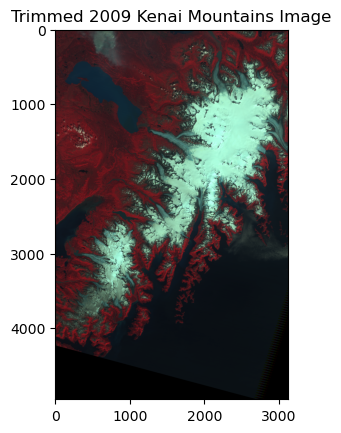

In [58]:
# Define a new bounding box to highlight only the Kenai Mountains
BoundingBox = {"left": 591185.0,"bottom": 6551985.0, # Values can be adjusted
               "right": 684815.0,"top": 6700615.0} # Values can be adjusted

# Open full false colour composite image and use it as a source
with rasterio.open('KenaiMountains/2009Data/KM2009_FullFCC.TIF') as KM2009Cropsrc:
    # Define a trim window using the new bounding box
    KM2009Trim = from_bounds(BoundingBox["left"], BoundingBox["bottom"], 
                             BoundingBox["right"], BoundingBox["top"],
                             transform=KM1986Cropsrc.transform) # transform helps convert the pixel value in the Bounding box to real coordinate on the image
    
    # Read the data within the trim window on the full false colour composite image
    KM2009Trim_Data = KM2009Cropsrc.read(window=KM2009Trim)
    
    # Update the profile of the trimmed image so it can be saved and used in the data analysis
    KM2009Trim_Transform = KM2009Cropsrc.window_transform(KM2009Trim)
    KM2009Trim_profile = KM2009Cropsrc.profile.copy()
    KM2009Trim_profile.update({
        "height": KM2009Trim_Data.shape[1],  # Updates the Pixel Height
        "width": KM2009Trim_Data.shape[2],  # Updates the Pixel Width
        "transform": KM2009Trim_Transform  # Updates the Pixel Values to include Pixels within the Trim Window
    })

# Save the trimmed raster as a TIF file in the 2009Data folder
with rasterio.open('KenaiMountains/2009Data/KM2009_FCC_Trim.TIF', "w", **KM2009Trim_profile) as dst:
    dst.write(KM2009Trim_Data)

# Display the trim 
# Use the plt.show() to check if the trimmed boundary is satisfactory for the glacier mask analysis
plt.imshow(KM2009Trim_Data.transpose((1, 2, 0))) # .transpose reorders the image to height (1), width(2), bands(0) the expected format for matplotlib
plt.title("Trimmed 2009 Kenai Mountains Image")
plt.show()

After the image has been saved, we can delete the unneccessary files and tidy up the 2009Data folder. If the files are needed at a later date they can be redownloaded following the steps above.

In [59]:
 # Create a loop that goes through all of the filenames in the 2009Data folder
for KM2009_filenames in os.listdir('KenaiMountains/2009Data'): 
    KM2009_FilePath = os.path.join('KenaiMountains/2009Data', KM2009_filenames)

    # Select all files in the folder apart from the Trimmed TIF
    if os.path.isfile(KM2009_FilePath) and KM2009_filenames != 'KM2009_FCC_Trim.TIF':
        os.remove(KM2009_FilePath) # Remove selected files
print("Deleted the files that are no longer required (Click Refresh on folder)")

Deleted the files that are no longer required (Click Refresh on folder)


Now that folder is more organised, we will calculate the total glacier area for the 1995 Landsat image. To do this we will carry out a pixel based classification of the image. We do this by normalising the Landsat Bands which are datasets with Digital Values of 0-255 (as they are an 8-bit image) to 0-1 (0 = not Glacier ice and snow, 1 = Glacier ice and snow). We then identify all pixels in the image that meet the reflectance threshold value to isolate glacier snow/ice (0.3 in all bands).

After Glacier ice and snow has been identified we will save the glacier mask to a new file, updating the profile metadata from the False Colour Composite Trim to reflect that the new image only has 1 band.

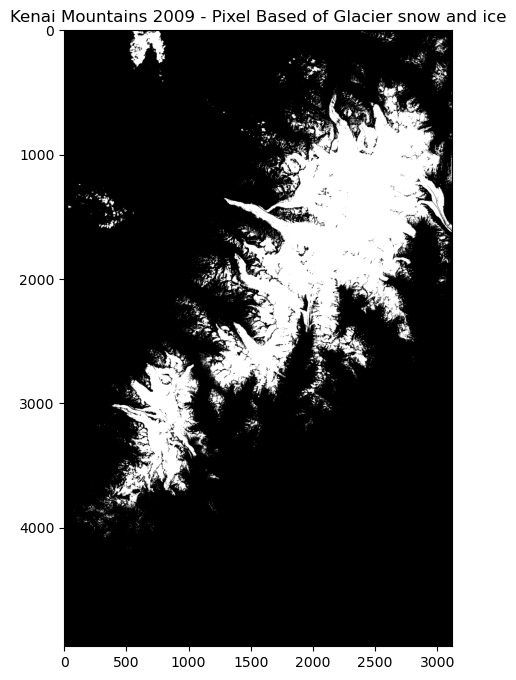

In [62]:
# Open the Trimmed TIF and use it as a source profile
with rasterio.open('KenaiMountains/2009Data/KM2009_FCC_Trim.TIF') as KM2009FCCsrc:
    KM2009_Normalised = KM2009FCCsrc.read()
    KM2009_profile = KM2009FCCsrc.profile

# The Landsat bands are Digitial Numbers so we then will normalize bands from 0-255 to 0-1
KM2009_Normalised = KM2009_Normalised.astype(np.float32)
KM2009_Normalised /= KM2009_Normalised.max()

# Normalise the each bands pixel value so that they are in a common range, set the reflectance value for ice and snow for each band
KM2009_Glacier = (KM2009_Normalised[0] > 0.2) & (KM2009_Normalised[1] > 0.2) & (KM2009_Normalised[2] > 0.3)

# Redefine the Glacier Mask to save it as a new TIF
KM2009_Glacier = KM2009_Glacier.astype(np.uint8)

# Update the profile so that it only has 1 band (Ice/snow)
KM2009_NewProfile = KM2009_profile.copy()
KM2009_NewProfile.update(dtype='uint8', count=1)

# Save the Glacier mask TIF to the Glacier Mask folder
with rasterio.open('KenaiMountains/GlacierMasks/KM2009_GlacierMask.TIF', 'w', **KM2009_NewProfile) as dst:
    dst.write(KM2009_Glacier, 1)

# Display the Glacier mask after it has been processed and saved.
plt.figure(figsize=(8, 8))
plt.imshow(KM2009_Glacier, cmap='gray') # Present the Glacier Mask is greyscale
plt.title('Kenai Mountains 2009 - Pixel Based of Glacier snow and ice')
plt.show()

After the pixel based classification has been successfully completed, we will calculate the glacier area by using the known pixel size in the glacier mask and converting to a real world measurement.

In [106]:
# Open the Glacier Mask for 2009
with rasterio.open('KenaiMountains/GlacierMasks/KM2009_GlacierMask.TIF') as KM2009GlacAreasrc:
    KM2009_GlacierMask = KM2009GlacAreasrc.read(1)  # Read the Glacier Mask band
    KM2009_Transfrom = KM2009GlacAreasrc.transform
    GlacPixelWidth = KM2009_Transfrom[0]     # pixel width
    GlacPixelHeight = -KM2009_Transfrom[4]    # pixel height (The value is negative so we add an "-" to make it positive)

# Calculate the Area per Pixel for the image, for Landsat TM it will be 30m x 30m 
KM2009_AreaPP = GlacPixelWidth * GlacPixelHeight  

# Calculate how many pixels in the image have been identified as snow/ice in the Glacier mask
KM2009_GlacPixel = np.sum(KM2009_GlacierMask == 1)

# Calculate the estimated area coverage of Glacier Ice and snow
TotalGlacArea2009 = (KM2009_GlacPixel * KM2009_AreaPP) / 1e6  # convert the value to square kilometers

# Print the Estimated Glacier area
print(f"Estimated 2009 Glacier Area: {TotalGlacArea2009:.2f} km²")

Estimated 2009 Glacier Area: 2404.73 km²


## Downloading and analysing the 2014 Landsat Scene ##

For the 2014 and 2024 Datasets the code slightly changes. We use the `landsat_ot_c2_l1` dataset which is the Landsat OLI/TIRS satellite for the scenes.

The code is mostly the same, but we carry out the normalisation sooner in the code as the more modern satellite has larger images so the format needs to be changed to be presented using Rasterio and Matplotlib.

In [70]:
# Use the scene_search function to get the product id of the 2014 Landsat scene
results_2014 = api.scene_search(
     # Landsat dataset used for 2014 image
    dataset = "landsat_ot_c2_l1", 
     # The latitude of the image
    lat = 60.09334,
    # The longtitude of the image
    lng = -150.97721, 
    # The start date of the search range
    start_date = "2014-09-24", 
    # The end date of the search range
    end_date = "2014-09-26", 
    # The Users Api key
    api_key=api_key 
)

# Loop through each 'scene' that appears in the results and  print out the 'entity_id' of the Landsat scene
for scene in results_2014['data']['results']:
    print("The Entity ID of the Landsat scene is",(scene['entityId'])) 

The Entity ID of the Landsat scene is LC80690182014268LGN01


For the 2014 and 2024 scenes, we are downloading them from the `landsat_ot_c2_l1` dataset. The `product_id` for the Collection 2 Level 1 Band Files will be different, so we print the options again to get the correct download `product_id`

In [ ]:
# This cell will provide the different download options for the Landsat dataset
api.dataset_download_options("landsat_ot_c2_l1")                             

The download for the Landsat OLI/TIRS images will take a few minutes to download as the folder contains larger and more images. 

In [71]:
# Use OS to create a 2009Data folder for the Landsat scene band files to be downloaded into
os.makedirs("KenaiMountains/2014Data", exist_ok=True) 

# Return the available download URLs for the Landsat scene Band files
KM_2014 = api.download_request(
    dataset="landsat_ot_c2_l1", # Landsat dataset
    entity_id="LC80690182014268LGN01", # Landsat scene ID (entity_id)
    product_id="5e81f14f92acf9ef", # Product ID (Landsat Band file)
)

# Download the Landsat scene images using the URL returned from download_request in the EE node
if 'data' in KM_2014 and 'availableDownloads' in KM_2014['data']:
    KM_2014Avail = KM_2014['data']['availableDownloads'] # Identify if the Landsat images are available to be downloaded
    if KM_2014Avail:
           # Access the first download URL returned from download_request
        KM2014downloadurl = KM_2014Avail[0]['url'] 
          # Set the file pathway to download into the 2014Data folder
        KM_2014File = os.path.join("KenaiMountains/2014Data", f"LC80690182014268LGN01.tar") 
        KM2014url = requests.get(KM2014downloadurl, stream=True)# Use requests to get the URL stored in 'KM2014downloadurl' 
        
         # Create the file and write it in binary mode to avoid corruption during the download
        with open(KM_2014File, "wb") as f:
            for chunk in KM2014url.iter_content(chunk_size=8192):# Download the folder in 8 KB Chunks
                if chunk:
                    f.write(chunk)

# Print text when the images are successfully downloaded
# Download may take a few minutes (folder is approximately 1GB)
print("2014 Kenai Mountain images downloaded!") 

2014 Kenai Mountain images downloaded!


After the images have been downloaded and extracted into the `2014Data` folder, we are going to build the false colour composite image of the 2014 Landsat scene.

To do this we are going to stack bands 5 (NIR), 4 (Red) and 3 (Green) and create a single 3D array using `NumPY`. 

In [72]:
# Extract the Landsat images into the 2014Data folder
with tarfile.open('KenaiMountains/2014Data/LC80690182014268LGN01.tar', 'r') as KM2014Tar:
    KM2014Tar.extractall('KenaiMountains/2014Data')

# Print text when extraction has been successfull
print("Images have been successfully extracted")

Images have been successfully extracted


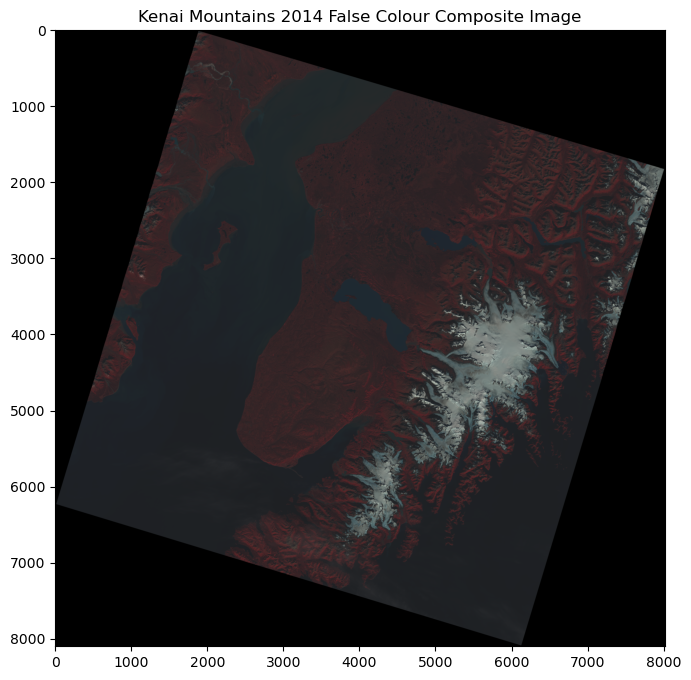

In [74]:
# Use Rasterio to open and read the band TIF files
with rasterio.open('KenaiMountains/2014Data/LC08_L1TP_069018_20140925_20200910_02_T1_B5.TIF') as KM2014_B5IMG:
    KM14B5 = KM2014_B5IMG.read(1) # Band 5 (NIR)
with rasterio.open('KenaiMountains/2014Data/LC08_L1TP_069018_20140925_20200910_02_T1_B4.TIF') as KM2014_B4IMG:
    KM14B4 = KM2014_B4IMG.read(1) # Band 4 (Red)
with rasterio.open('KenaiMountains/2014Data/LC08_L1TP_069018_20140925_20200910_02_T1_B3.TIF') as KM2014_B3IMG:
    KM14B3 = KM2014_B3IMG.read(1) # Band 3 (Green)

# Stack the Landsat bands using NumPy to create a single 3D Array
KM2014_FFCstack = np.dstack((KM14B5, KM14B4, KM14B3))

# Normalise the bands in the false colour composite image as the image is to large to print using matplotlib
KM2014_Normalised = KM2014_FFCstack.astype(np.float32)
KM2014_Normalised /= KM2014_Normalised.max()

# Print the stacked band array to show the 2014 false colour composite image 
plt.figure(figsize=(8, 8))
plt.imshow(KM2014_Normalised)
plt.title("Kenai Mountains 2014 False Colour Composite Image")
plt.show()

In [76]:
# Open one of the bands (NIR) to get its profile and use it as a source for the image
with rasterio.open('KenaiMountains/2014Data/LC08_L1TP_069018_20140925_20200910_02_T1_B5.TIF') as KM2014_source:
    KM2014_ImgProfile = KM2014_source.profile

# Update the profile for all of the bands 
# All bands will be updated using Band 5 as the source
KM2014_ImgProfile.update(
    count=3,  # The count is set to 3 as we are using 3 bands (NIR, Red and Green)
    dtype=KM2014_Normalised.dtype  # Set the data type to be the same as the false colour composite
)

# Save the False Colour Composite to the 2014Data folder
with rasterio.open('KenaiMountains/2014Data/KM2014_FullFCC.TIF', 'w', **KM2014_ImgProfile) as KM2014_FCCdownload:
# Use .write to save the image to the 2009Data folder
    KM2014_FCCdownload.write(KM2014_Normalised.transpose(2, 0, 1))   # .transpose reorders the image to bands/count(2), height (0), width(1)
print("Image has been saved as KM2014_FullFCC.TIF in KenaiMountain2014")

Image has been saved as KM2014_FullFCC.TIF in KenaiMountain2014


Now we can trim the 2014 Landsat scene so that only the Kenai Mountains is visible in the image. This will be useful for providing an accuracte estimation of the glacier area for the 2009 period.

To include more area (zoom out) on the image:
- Decrease 'left'
- Increase 'right'
- Decrease 'bottom'
- Increase 'top'

To include less area (Zoom in):
- Increase 'left'
- Decrease 'Right'
- Increase 'bottom'
- Decrease 'top'

In [77]:
# Use Rasterio to get the current bounds for the 2014 false colour composite tif
with rasterio.open('KenaiMountains/2014Data/KM2014_FullFCC.TIF') as KM2014FCCsrc:
    print(KM2014FCCsrc.bounds)

BoundingBox(left=491985.0, bottom=6541485.0, right=732615.0, top=6784515.0)


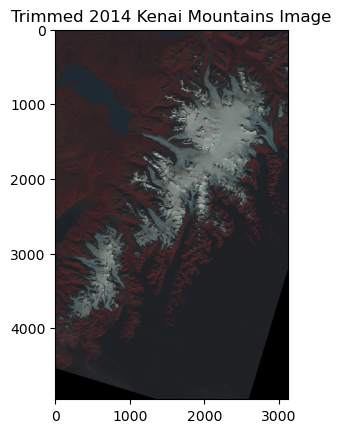

In [83]:
# Define a new bounding box to highlight only the Kenai Mountains
BoundingBox = {"left": 601185.0,"bottom": 6551985.0, # Value can be adjusted
               "right": 694815.0,"top": 6700615.0} # Value can be adjusted

# Open full false colour composite image and use it as a source
with rasterio.open('KenaiMountains/2014Data/KM2014_FullFCC.TIF') as KM2014Cropsrc:
    # Define a trim window using the new bounding box
    KM2014Trim = from_bounds(BoundingBox["left"], BoundingBox["bottom"],
                             BoundingBox["right"], BoundingBox["top"], 
                             transform=KM2014Cropsrc.transform)  # transform helps convert the pixel value in the Bounding box to real coordinate on the image
    
    # Read the data within the trim window on the full false colour composite image
    KM2014Trim_Data = KM2014Cropsrc.read(window=KM2014Trim)
    
     # Update the profile of the trimmed image so it can be saved and used in the data analysis
    KM2014Trim_Transform = KM2014Cropsrc.window_transform(KM2014Trim)
    KM2014Trim_profile = KM2014Cropsrc.profile.copy()
    KM2014Trim_profile.update({
        "height": KM2014Trim_Data.shape[1], # Updates the Pixel Height
        "width": KM2014Trim_Data.shape[2], # Updates the Pixel Width
        "transform": KM2014Trim_Transform # Updates the Pixel Values to include Pixels within the Trim Window
    })

# Save the trimmed raster as a TIF file in the 2014Data folder
with rasterio.open('KenaiMountains/2014Data/KM2014_FCC_Trim.TIF', "w", **KM2014Trim_profile) as dst:
    dst.write(KM2014Trim_Data)

# Display the trim 
# Use the plt.show() to check if the trimmed boundary is satisfactory for the glacier mask analysis
plt.imshow(KM2014Trim_Data.transpose((1, 2, 0))) # .transpose reorders the image to height (1), width(2), bands(0) the expected format for matplotlib
plt.title("Trimmed 2014 Kenai Mountains Image")
plt.show()

After the image has been saved, we can delete the unneccessary files and tidy up the `2014Data` folder. If the files are needed at a later date they can be redownloaded following the steps above.

In [84]:
 # Create a loop that goes through all of the filenames in the 2014Data folder
for KM2014_filenames in os.listdir('KenaiMountains/2014Data'): 
    KM2014_FilePath = os.path.join('KenaiMountains/2014Data', KM2014_filenames) 

    # Select all files in the folder apart from the Trimmed TIF
    if os.path.isfile(KM2014_FilePath) and KM2014_filenames !='KM2014_FCC_Trim.TIF':
        os.remove(KM2014_FilePath) # Remove selected files
print("Deleted the files that are no longer required (Click Refresh on folder)")

Deleted the files that are no longer required (Click Refresh on folder)


Now that folder is more organised, we will calculate the total glacier area for the 2014 Landsat image. To do this we will carry out a pixel based classification of the image. We do this by using the normalised Landsat Bands and then identifying all pixels in the image that meet the reflectance threshold value to isolate glacier snow/ice (0.3 in all bands).

After Glacier ice and snow has been identified we will save the glacier mask to a new file, updating the profile metadata from the False Colour Composite Trim to reflect that the new image only has 1 band.

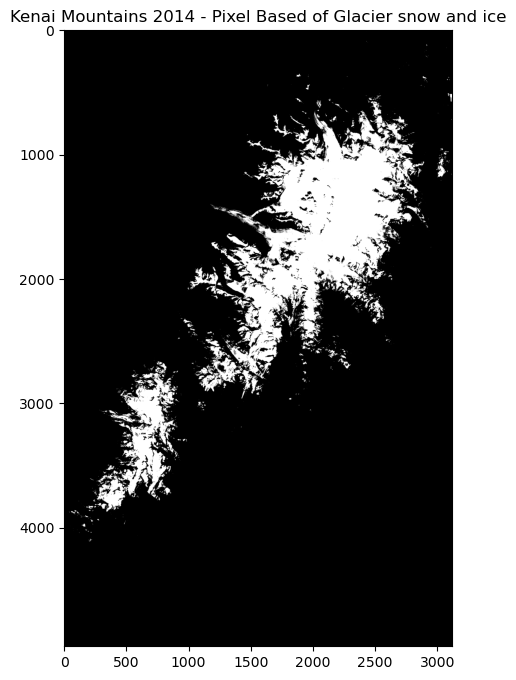

In [92]:
# Open the Trimmed TIF and use it as a source profile
with rasterio.open('KenaiMountains/2014Data/KM2014_FCC_Trim.TIF') as KM2014FCCsrc:
    KM2014_Normalised = KM2014FCCsrc.read()
    KM2014_profile = KM2014FCCsrc.profile

# As bands have already been normalised this step is not repeated
# Normalise the each bands pixel value so that they are in a common range, set the reflectance value for ice and snow for each band
KM2014_Glacier = (KM2014_Normalised[0] > 0.3) & (KM2014_Normalised[1] > 0.3) & (KM2014_Normalised[2] > 0.3)

# Redefine the Glacier Mask to save it as a new TIF
KM2014_Glacier = KM2014_Glacier.astype(np.uint8)

# Update the profile so that it only has 1 band (Ice/snow)
KM2014_NewProfile = KM2014_profile.copy()
KM2014_NewProfile.update(dtype='uint8', count=1)

# Save the Glacier mask TIF to the Glacier Mask folder
with rasterio.open('KenaiMountains/GlacierMasks/KM2014_GlacierMask.TIF', 'w', **KM2014_NewProfile) as dst:
    dst.write(KM2014_Glacier, 1)

# Display the Glacier mask after it has been processed and saved.
plt.figure(figsize=(8, 8))
plt.imshow(KM2014_Glacier, cmap='gray') # Present the Glacier Mask is greyscale
plt.title('Kenai Mountains 2014 - Pixel Based of Glacier snow and ice')
plt.show()

After the pixel based classification has been successfully completed, we will calculate the glacier area by using the known pixel size in the glacier mask and converting to a real world measurement (km²).

In [93]:
# Open the Glacier Mask for 2014
with rasterio.open('KenaiMountains/GlacierMasks/KM2014_GlacierMask.TIF') as KM2014GlacAreasrc:
    KM2014_GlacierMask = KM2014GlacAreasrc.read(1)  # Read the Glacier Mask band
    KM2014_Transfrom = KM2014GlacAreasrc.transform
    GlacPixelWidth = KM2014_Transfrom[0]     # pixel width
    GlacPixelHeight = -KM2014_Transfrom[4]    # pixel height (The value is negative so we add an "-" to make it positive)

# Calculate the Area per Pixel for the image, for Landsat OLI/TIRS it will be 30m x 30m 
KM2014_AreaPP = GlacPixelWidth * GlacPixelHeight 

# Calculate how many pixels in the image have been identified as snow/ice in the Glacier mask
KM2014_GlacPixel = np.sum(KM2014_GlacierMask == 1)

# Calculate the estimated area coverage of Glacier Ice and snow
TotalGlacArea2014 = (KM2014_GlacPixel * KM2014_AreaPP) / 1e6  #  convert the value to square kilometers

# Print the Estimated Glacier area
print(f"Estimated 2014 Glacier Area: {TotalGlacArea2014:.2f} km²")

Estimated 2014 Glacier Area: 1620.14 km²


## Downloading and analysing the 2024 Landsat Scene ##

For the 2024 Dataset the code is the same as the 2014 analysis. We use the `landsat_ot_c2_l1` dataset which is the Landsat OLI/TIRS satellite for the scene.

In [ ]:
# Use the scene_search function to get the product id of the 2024 Landsat scene
results_2024 = api.scene_search(
    # Landsat dataset used for 2024 image
    dataset = "landsat_ot_c2_l1", 
    # The latitude of the image
    lat = 60.09328, 
    # The longtitude of the image
    lng = -149.48212, 
    # The start date of the search range
    start_date = "2024-08-20",
    # The end date of the search range
    end_date = "2024-08-20", 
    # The Users Api key
    api_key=api_key 
)

# Loop through each 'scene' that appears in the results and  print out the 'entity_id' of the Landsat scene
for scene in results_2024['data']['results']:
    print("The Entity ID of the Landsat scene is",(scene['entityId'])) 

We are using the same `product_id` as the 2014 analysis as we are extracting images from the same satellite dataset.

In [95]:
# Use OS to create a 2009Data folder for the Landsat scene band files to be downloaded into
os.makedirs("KenaiMountains/2024Data", exist_ok=True) 

# Return the available download URLs for the Landsat scene Band files
KM_2024 = api.download_request(
    dataset="landsat_ot_c2_l1", # Landsat dataset
    entity_id="LC90680182024233LGN00", # Landsat scene ID (entity_id)
    product_id="5e81f14f92acf9ef", # Product ID (Landsat Band file), the same as the 2014 dataset
)

# Download the Landsat scene images using the URL returned from download_request in the EE node
if 'data' in KM_2024 and 'availableDownloads' in KM_2024['data']:
    KM_2024Avail = KM_2024['data']['availableDownloads']# Identify if the Landsat images are available to be downloaded
    if KM_2024Avail:
        # Access the first download URL returned from download_request
        KM2024downloadurl = KM_2024Avail[0]['url'] 
         # Set the file pathway to download into the 2014Data folder
        KM_2024File = os.path.join("KenaiMountains/2024Data", f"LC90680182024233LGN00.tar") 
        KM2024url = requests.get(KM2024downloadurl, stream=True) # Use requests to get the URL stored in 'KM2024downloadurl' 

        # Create the file and write it in binary mode to avoid corruption during the download
        with open(KM_2024File, "wb") as f: 
            for chunk in KM2024url.iter_content(chunk_size=8192): # Download the folder in 8 KB Chunk
                if chunk:
                    f.write(chunk)

# Print text when the images are successfully downloaded
# Download may take a few minutes (folder is approximately 1GB)
print("2024 Kenai Mountain images downloaded!") 

2024 Kenai Mountain images downloaded!


In [96]:
# Extract the Landsat images into the 2024Data folder
with tarfile.open('KenaiMountains/2024Data/LC90680182024233LGN00.tar', 'r') as KM2024Tar:
    KM2024Tar.extractall('KenaiMountains/2024Data')

# Print text when extraction has been successfull
print("Images have been successfully extracted")

Images have been successfully extracted


After the images have been downloaded and extracted into the `2024Data` folder, we are going to build the false colour composite image of the 2024 Landsat scene.

To do this we are going to stack bands 5 (NIR), 4 (Red) and 3 (Green) and create a single 3D array using `NumPY`. 

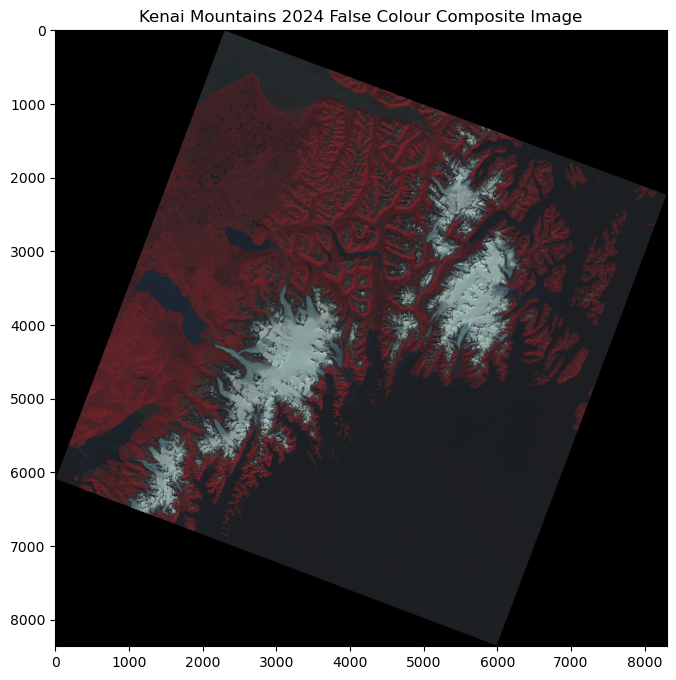

In [97]:
# Use Rasterio to open and read the band TIF files
with rasterio.open('KenaiMountains/2024Data/LC09_L1TP_068018_20240820_20240820_02_T1_B5.TIF') as KM2024_B5IMG:
    KM24B5 = KM2024_B5IMG.read(1) # Band 5 (NIR)
with rasterio.open('KenaiMountains/2024Data/LC09_L1TP_068018_20240820_20240820_02_T1_B4.TIF') as KM2024_B4IMG:
    KM24B4 = KM2024_B4IMG.read(1) # Band 4 (Red)
with rasterio.open('KenaiMountains/2024Data/LC09_L1TP_068018_20240820_20240820_02_T1_B3.TIF') as KM2024_B3IMG:
    KM24B3 = KM2024_B3IMG.read(1) # Band 3 (Green)

# Stack the Landsat bands using NumPy to create a single 3D Array
KM2024_falsecolourstack = np.dstack((KM24B5, KM24B4, KM24B3))

# Normalise the bands in the false colour composite image as the image is to large to print using matplotlib
KM2024_Normalised = KM2024_falsecolourstack.astype(np.float32)
KM2024_Normalised /= KM2024_Normalised.max()

# Print the stacked band array to show the 2024 false colour composite image
plt.figure(figsize=(8, 8))
plt.imshow(KM2024_Normalised)
plt.title("Kenai Mountains 2024 False Colour Composite Image")
plt.show()

In [98]:
# Open one of the bands (NIR) to get its profile and use it as a source for the image
with rasterio.open('KenaiMountains/2024Data/LC09_L1TP_068018_20240820_20240820_02_T1_B5.TIF') as KM2024_source:
    KM2024_ImgProfile = KM2024_source.profile

# Update the profile for all of the bands 
# All bands will be updated using Band 5 as the source
KM2024_ImgProfile.update(
    count=3,  #  The count is set to 3 as we are using 3 bands (NIR, Red and Green)
    dtype=KM2024_Normalised.dtype  #  Set the data type to be the same as the false colour composite
)

# Save the False Colour Composite to the 2024Data folder
with rasterio.open('KenaiMountains/2024Data/KM2024_FullFCC.TIF', 'w', **KM2024_ImgProfile) as KM2024_FCCdownload:
# Use .write to save the image to the 2009Data folder
    KM2024_FCCdownload.write(KM2024_Normalised.transpose(2, 0, 1))   # .transpose reorders the image to bands/count(2), height (0), width(1)
print("Image has been saved as KM2024_FullFCC.TIF in KenaiMountain2014")

Image has been saved as KM2024_FullFCC.TIF in KenaiMountain2014


Now we can trim the 2024 Landsat scene so that only the Kenai Mountains is visible in the image. This will be useful for providing an accuracte estimation of the glacier area for the 2009 period.

To include more area (zoom out) on the image:
- Decrease 'left'
- Increase 'right'
- Decrease 'bottom'
- Increase 'top'

To include less area (Zoom in):
- Increase 'left'
- Decrease 'Right'
- Increase 'bottom'
- Decrease 'top'

In [99]:
# Use Rasterio to get the current bounds for the 2024 false colour composite tif
with rasterio.open('KenaiMountains/2024Data/KM2024_FullFCC.TIF') as KM2024FCCsrc:
    print(KM2024FCCsrc.bounds)

BoundingBox(left=237285.0, bottom=6538485.0, right=486315.0, top=6789315.0)


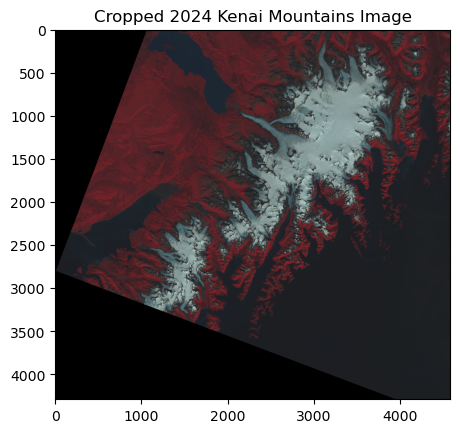

In [102]:
# Define a new bounding box to highlight only the Kenai Mountains
BoundingBox = {"left": 191185.0,"bottom": 6561985.0,
               "right": 374815.0,"top": 6690615.0}

# Open full false colour composite image and use it as a source
with rasterio.open('KenaiMountains/2024Data/KM2024_FullFCC.TIF') as KM2024Cropsrc:
    # Define a trim window using the new bounding box
    KM2024Trim = from_bounds(BoundingBox["left"], BoundingBox["bottom"], 
                             BoundingBox["right"], BoundingBox["top"],
                             transform=KM2024Cropsrc.transform)  # transform helps convert the pixel value in the Bounding box to real coordinate on the image
    
    # Read the data within the trim window on the full false colour composite image
    KM2024Trim_Data = KM2024Cropsrc.read(window=KM2024Trim)
    
    # Update the profile of the trimmed image so it can be saved and used in the data analysis
    KM2024Trim_Transform = KM2024Cropsrc.window_transform(KM2024Trim)
    KM2024Trim_profile = KM2024Cropsrc.profile.copy()
    KM2024Trim_profile.update({
        "height": KM2024Trim_Data.shape[1], # Updates the Pixel Height
        "width": KM2024Trim_Data.shape[2], # Updates the Pixel Width
        "transform": KM2024Trim_Transform # Updates the Pixel Values to include Pixels within the Trim Window
    })

# Save the trimmed raster as a TIF file in the 2024Data folder
with rasterio.open('KenaiMountains/2024Data/KM2024_FCC_Trim.TIF', "w", **KM2024Trim_profile) as dst:
    dst.write(KM2024Trim_Data)

# Display the trim 
# Use the plt.show() to check if the trimmed boundary is satisfactory for the glacier mask analysis
plt.imshow(KM2024Trim_Data.transpose((1, 2, 0))) # .transpose reorders the image to height (1), width(2), bands(0) the expected format for matplotlib
plt.title("Cropped 2024 Kenai Mountains Image")
plt.show()

After the image has been saved, we can delete the unneccessary files and tidy up the `2024Data` folder. If the files are needed at a later date they can be redownloaded following the steps above.

In [103]:
# Create a loop that goes through all of the filenames in the 2024Data folder
for KM2024_filenames in os.listdir('KenaiMountains/2024Data'): 
    KM2024_FilePath = os.path.join('KenaiMountains/2024Data', KM2024_filenames)

     # Select all files in the folder apart from the Trimmed TIF
    if os.path.isfile(KM2024_FilePath) and KM2024_filenames !='KM2024_FCC_Trim.TIF':
        os.remove(KM2024_FilePath) # Remove selected files
print("Deleted the files that are no longer required (Click Refresh on folder)")

Deleted the files that are no longer required (Click Refresh on folder)


Now that folder is more organised, we will calculate the total glacier area for the 2024 Landsat image. To do this we will carry out a pixel based classification of the image. We do this by using the normalised Landsat Bands and then identifying all pixels in the image that meet the reflectance threshold value to isolate glacier snow/ice (0.3 in all bands).

After Glacier ice and snow has been identified we will save the glacier mask to a new file, updating the profile metadata from the False Colour Composite Trim to reflect that the new image only has 1 band.

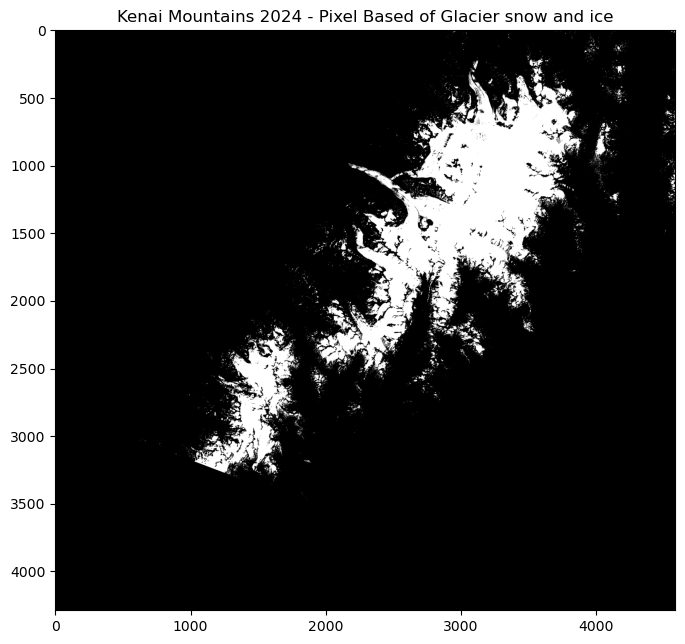

In [104]:
# Open the Trimmed TIF and use it as a source profile
with rasterio.open('KenaiMountains/2024Data/KM2024_FCC_Trim.TIF') as KM2024FCCsrc:
    KM2024_Normalised = KM2024FCCsrc.read()
    KM2024_profile = KM2024FCCsrc.profile

# As bands have already been normalised this step is not repeated
# Normalise the each bands pixel value so that they are in a common range, set the reflectance value for ice and snow for each band
KM2024_Glacier = (KM2024_Normalised[0] > 0.3) & (KM2024_Normalised[1] > 0.3) & (KM2024_Normalised[2] > 0.3)

# Redefine the Glacier Mask to save it as a new TIF
KM2024_Glacier = KM2024_Glacier.astype(np.uint8)

# Update the profile so that it only has 1 band (Ice/snow)
KM2024_NewProfile = KM2024_profile.copy()
KM2024_NewProfile.update(dtype='uint8', count=1)

# Save the Glacier mask TIF to the Glacier Mask folder
with rasterio.open('KenaiMountains/GlacierMasks/KM2024_GlacierMask.TIF', 'w', **KM2024_NewProfile) as dst:
    dst.write(KM2024_Glacier, 1)

# Display the Glacier mask after it has been processed and saved.
plt.figure(figsize=(8, 8))
plt.imshow(KM2024_Glacier, cmap='gray') # Present the Glacier Mask is greyscale
plt.title('Kenai Mountains 2024 - Pixel Based of Glacier snow and ice')
plt.show()

After the pixel based classification has been successfully completed, we will calculate the glacier area by using the known pixel size in the glacier mask and converting to a real world measurement (km²).

In [105]:
# Open the Glacier Mask for 2024
with rasterio.open('KenaiMountains/GlacierMasks/KM2024_GlacierMask.TIF') as KM2024GlacAreasrc:
    KM2024_GlacierMask = KM2024GlacAreasrc.read(1)  # Read the Glacier Mask band
    KM2024_Transfrom = KM2024GlacAreasrc.transform
    GlacPixelWidth = KM2024_Transfrom[0]     # pixel width
    GlacPixelHeight = -KM2024_Transfrom[4]   # pixel height (The value is negative so we add an "-" to make it positive)

# Calculate the Area per Pixel for the image, for Landsat OLI/TIRS it will be 30m x 30m 
KM2024_AreaPP = GlacPixelWidth * GlacPixelHeight 

# Calculate how many pixels in the image have been identified as snow/ice in the Glacier mask
KM2024_GlacPixel = np.sum(KM2024_GlacierMask == 1)

# Calculate the estimated area coverage of Glacier Ice and snow
TotalGlacArea2024 = (KM2024_GlacPixel * KM2024_AreaPP) / 1e6   # convert the value to square kilometerss

# Print the Estimated Glacier area
print(f"Estimated 2024 Glacier Area: {TotalGlacArea2024:.2f} km²")

Estimated 2024 Glacier Area: 1762.00 km²


In [ ]:
# Logs out the existing USGS account for the script
# Ensure you log out using this cell whenever you are finished to prevent any issues revisiting or adapting the script
api.logout()
print("Log out successfull!")